In [1]:
import numpy as np
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from pyomo.environ import Constraint
import logging
import datetime

c:\miniconda3\envs\test2\Lib\site-packages\pypsa\networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



In [2]:
%matplotlib inline
logging.basicConfig(level="INFO")

## Δεδομένα Παραγωγής και Κατανάλωσης

In [3]:
data=pd.read_csv("time_series_60min_singleindex.csv", parse_dates=True)
data.set_index(['utc_timestamp'], inplace=True)
gr_cols = [col for col in data.columns if col.startswith('GR_')]
data=data[gr_cols]
# data=data['2015-01-01T12:00:00Z':'2015-01-01T12:00:00Z']
data=data['2015-01-01':'2020-09-30']

data=data.fillna(method='pad')
data=data.fillna(method='backfill')
data_load=data['GR_load_actual_entsoe_transparency']/2000 #Υποθετω οτι ειναι για 10.000.000/2.000 = 5.000 άτομα
data_pvprod=data['GR_solar_generation_actual']/(2115/5)  
data_pvprod.describe()

count    1.000000
mean     1.174941
std           NaN
min      1.174941
25%      1.174941
50%      1.174941
75%      1.174941
max      1.174941
Name: GR_solar_generation_actual, dtype: float64

In [52]:
data_load.describe()

count    1.000000
mean     3.134375
std           NaN
min      3.134375
25%      3.134375
50%      3.134375
75%      3.134375
max      3.134375
Name: GR_load_actual_entsoe_transparency, dtype: float64

In [53]:
data_pvprod.describe()

count    1.000000
mean     1.174941
std           NaN
min      1.174941
25%      1.174941
50%      1.174941
75%      1.174941
max      1.174941
Name: GR_solar_generation_actual, dtype: float64

## Προσομοίωση Δικτύου

In [54]:
network = pypsa.Network()
network.set_snapshots(data.index)

In [55]:
#Add buses and carriers to the network
network.add("Bus", "Diesel", carrier='AC')
network.add("Carrier", "diesel",co2_emissions=0) 

network.add("Bus", "Solar", carrier="AC")
network.add("Carrier", "solar")

#Add line
network.add("Line","Line",bus0="Diesel",bus1="Solar", r=0.01, x=0.1, s_nom_extendable=True)

#Add generators
network.add(
    "Generator",
    "Diesel Gen",
    bus="Diesel",
    carrier="diesel",
    p_nom=5, #MW
    p_nom_extendable=False,
    p_min_pu=0.3, 
    control="Slack",
    capital_cost=0, #Capital cost of extending p_nom by 1 MW (€/MW)
    marginal_cost=305,#diesel:0.2€/kWh, CO2 emissions: 80-85€/tCO2*1.27 tonnes/MWh = 105€/MWh (€/MWh)
    )

network.add(
    "Generator",
    "PV Park",
    bus="Solar", 
    carrier="solar",
    control="PV", 
    p_nom=1, #MW 
    p_nom_extendable=False,
    p_max_pu=np.array(data_pvprod),
    capital_cost=0, #Capital cost of extending p_nom by 1 MW (€/MW)
    marginal_cost=24 # 20-60€/MWh
    )

#Add loads
network.add("Load", "load 1", bus="Solar", p_set=np.array(data_load)) 


## Προσωμοίωση Power to Gas  

In [56]:
network.add("Bus", "Hydrogen", carrier="hydrogen")

network.add("Carrier", "hydrogen")
network.add("Carrier", "electrolysis")
network.add("Carrier", "fuel cell")

#Add electrolysis and fuel cell links
network.add(
    "Link",
    "Electrolysis",
    bus0="Solar",
    bus1="Hydrogen",
    carrier="electrolysis",
    efficiency=0.7, 
    p_nom=2.5, #Limit of active power which can pass through link. 
    p_nom_extendable=True, 
    #p_min_pu=0.2, 
    #p_max_pu=1, 
    capital_cost=1000000/5, #Capital cost of extending p_nom by 1 MW (€/MW)
    marginal_cost=110,  #0.06-0.2€ per kWh (€/MWh)
    )    

network.add(
    "Link",
    "Fuel Cell",
    bus0="Hydrogen",
    bus1="Solar",
    carrier="fuel cell",
    efficiency=0.6, 
    p_nom=1.2, #Limit of active power which can pass through link. 
    #p_max_pu=1, 
    p_nom_extendable=True,
    capital_cost=1000000/5, #Capital cost of extending p_nom by 1 MW (€/MW)
    marginal_cost=110,# 0.1-0.3€ per kWh (€/MWh)
    )

#Add H2 store 
network.add(
    "Store", 
    "H2", 
    bus="Hydrogen", 
    carrier="hydrogen", 
    e_nom=15, #Nominal energy capacity (MWh)
    # e_cyclic=True, 
    e_nom_extendable=True,
    capital_cost=40000/5, #Capital cost of extending p_nom by 1 MW (€/MWh) 
    marginal_cost=10,
    )

#network.add("Load", "load 2", bus="Hydrogen", p_set=0.3)


## Ροη φορτιου και βελτιστοποιηση
Χρησιμοποείται η εντολή network.optimize() για να τρέξει το σύστημα και να βελτιστοποιηθεί το αποτέλεσμα. Ο χρόνος εκτέλεσης ειναι 21min 7sec.

In [57]:
network.optimize(network.snapshots, solver_name="glpk", solver_options={})

<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast

<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast

<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.4s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 12 primals, 20 duals
Objective: -8.59e+05
Solver model: not available
Solver message: optimal



GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --lp C:\Users\2F06~1\AppData\Local\Temp\linopy-problem-_7t3iyss.lp --output
 C:\Users\2F06~1\AppData\Local\Temp\linopy-solve-zz4jgfhh.sol
Reading problem data from 'C:\Users\2F06~1\AppData\Local\Temp\linopy-problem-_7t3iyss.lp'...
20 rows, 12 columns, 32 non-zeros
154 lines were read
GLPK Simplex Optimizer, v4.65
20 rows, 12 columns, 32 non-zeros
Preprocessing...
2 rows, 3 columns, 5 non-zeros
Scaling...
 A: min|aij| =  6.000e-01  max|aij| =  1.000e+00  ratio =  1.667e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 2
      0: obj =  -8.595032750e+05 inf =   4.594e-01 (1)
      1: obj =  -8.593741740e+05 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0 Mb (40412 bytes)
Writing basic solution to 'C:\Users\2F06~1\AppData\Local\Temp\linopy-solve-zz4jgfhh.sol'...


('ok', 'optimal')

## Αποτελέσματα και Σχόλια
Παρακάτω εμφανίζονται τα δεδομένα της βελτιστοποίησης οπως είναι: το objective function, το μονογραμμικο διάγραμμα απο το network.iplot() της pypsa και γραφικές παραστάσεις στις οποίες απεικονίζονται η παραγωγή, η ζήτηση, ο ηλεκτρολυτης και το fuel cell και τέλος το store υδρογονου.

In [58]:
#total system cost for the snapshots optimised
network.objective 

-859374.174

In [59]:
network.iplot()

{'data': [{'x': Diesel     -1.0
   Solar       1.0
   Hydrogen    0.0
   Name: x, dtype: float64,
   'y': Diesel     -0.333333
   Solar      -0.333333
   Hydrogen    0.666667
   Name: y, dtype: float64,
   'text': Index(['Bus Diesel', 'Bus Solar', 'Bus Hydrogen'], dtype='object', name='Bus'),
   'type': 'scatter',
   'mode': 'markers',
   'hoverinfo': 'text',
   'opacity': 1,
   'marker': {'color': 'cadetblue', 'size': 10}},
  {'x': Link
   Electrolysis    0.5
   Fuel Cell       0.5
   dtype: float64,
   'y': Link
   Electrolysis    0.166667
   Fuel Cell       0.166667
   dtype: float64,
   'text': Index(['Link Electrolysis', 'Link Fuel Cell'], dtype='object', name='Link'),
   'type': 'scatter',
   'mode': 'markers',
   'hoverinfo': 'text',
   'marker': {'opacity': 0.0}},
  {'x': Line
   Line    0.0
   dtype: float64,
   'y': Line
   Line   -0.333333
   dtype: float64,
   'text': Index(['Line Line'], dtype='object', name='Line'),
   'type': 'scatter',
   'mode': 'markers',
   'hoverinf

Οι δύο πρωτες γραφικές αφορούν το σύστημα για ολόκληρο το διάστημα της προσωμόιωσης (5 χρονια, 9 μηνες) και παρατηρούμε ότι το Power to Gas σύστημα δεν λειτουργει.\
Αυτο συμβαίνει διότι με τις σημερινές τιμές των στοιχείων το σύστημα χρησιμοποιεί την ενέργεια απο την γεννητρια diesel ακομα και αν το λειτουργικο της κοστος της ειναι πιο ακριβό, αφού το κόστος κεφαλαίου του ηλεκτρολύτη και του fuel cell ειναι πολυ ακριβά.

<Axes: xlabel='snapshot'>

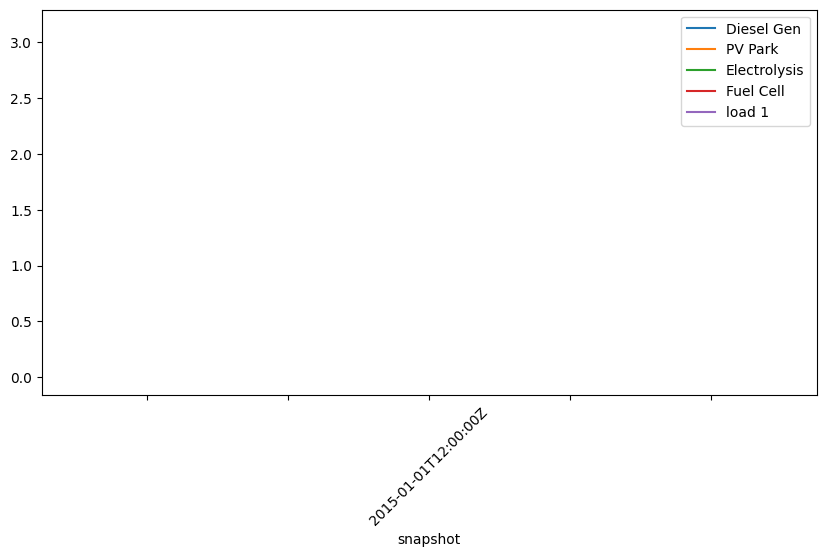

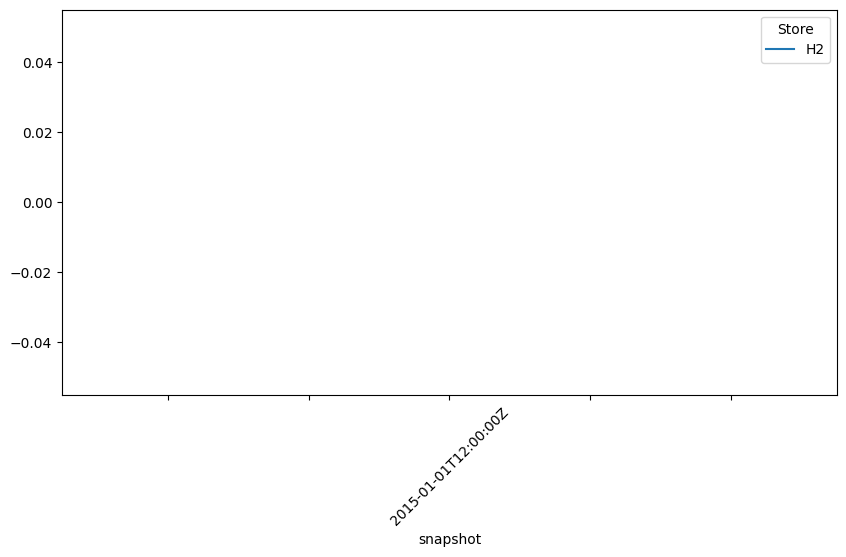

In [60]:
df=pd.concat([network.generators_t.p, network.links_t.p0, network.loads_t.p],axis=1)
df.plot(rot=45)
network.stores_t.e.plot(rot=45)

Στις παρακάτω γραφικές μπορούμε να δούμε την απόκριση του συστηματος για το διάστημα **'2020-07-22':'2020-07-25'** όπου και είναι εμφανές ότι η γεννήτρια λειτουργεί τα βράδια, που δεν υπάρχει ΦΒ παραγωγή, ώστε να καλύψει το φορτίο, ενώ τα μεσημέρια η γεννήτρια λειτουργεί στο 30% ονομαστικής ισχύος για λόγους ευστάθειας και το ΦΒ πάρκο παράγει ενέργεια και η ενέργεια αυτή προτιμάται καθώς το λειτουργικό της κόστος είναι πιο φθηνό.

<Axes: xlabel='snapshot'>

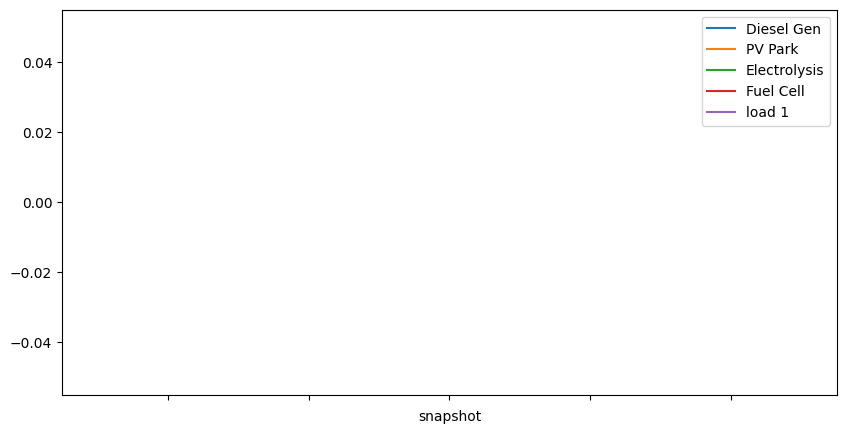

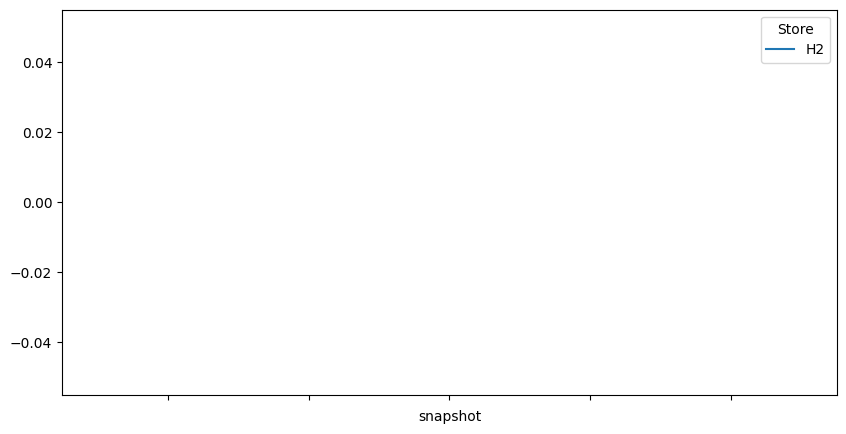

In [61]:
df=pd.concat([network.generators_t.p, network.links_t.p0, network.loads_t.p],axis=1)
df['2020-07-22':'2020-07-25'].plot(rot=45)
network.stores_t.e['2020-07-22':'2020-07-25'].plot(rot=45)